# Optimización de Parámetros - ARIMA (uno)

In [1]:
## Get current work directory to load all the custom modules
from pathlib import Path
import sys
BASE_DIR = Path().absolute().resolve(strict=True).parent.parent.parent
if str(BASE_DIR) not in sys.path:
    sys.path.append(str(BASE_DIR))

In [2]:
DATA_PATH = os.path.join(BASE_DIR, 'data', 'autos')
print(DATA_PATH)

/workspace/Externos/TimeSeries/BenchMark/data/autos


In [3]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer

In [4]:
import statsmodels.api as sm
# from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import r2_score
from matplotlib import pyplot as plt
import optuna
import datetime

In [5]:

from helpers.general import  print_forecasting_results
from sklearn.model_selection import cross_val_score
from modulos.arima.gruas.general import format_timeseries, show_results_r2, arima_forecasting, total_forecasting, show_optimizer_results

In [6]:
data = pd.read_csv(os.path.join(DATA_PATH, 'producto.csv'), parse_dates=['Periodo'])
data.head()

,Periodo,idArticulo,ventas,DescProducto
0,2021-10-01,9950,74.0,REFRIGERANTE COOLANT AZUL/NATURAL TRANSP. GAL...
1,2021-09-01,9950,25.0,REFRIGERANTE COOLANT AZUL/NATURAL TRANSP. GAL...
2,2021-08-01,9950,28.0,REFRIGERANTE COOLANT AZUL/NATURAL TRANSP. GAL...
3,2021-07-01,9950,15.0,REFRIGERANTE COOLANT AZUL/NATURAL TRANSP. GAL...
4,2021-06-01,9950,13.0,REFRIGERANTE COOLANT AZUL/NATURAL TRANSP. GAL...


In [7]:
data['Periodo'][0]

Timestamp('2021-10-01 00:00:00')

In [8]:
# Pivotando las tablas y llenando de ceros las ventas que no existen.
df_time = format_timeseries(data)
df_time.tail()

idArticulo,551,594,963,1208,1224,1627,3090,3745,3882,3883,...,20263,20301,20305,20310,20697,20769,21577,23900,26158,27165
Periodo,,,,,,,,,,,,,,,,,,,,,
2021-06-01,4.0,3.0,6.0,140.0,0.0,5.0,4.0,5.0,2.0,0.0,...,4.0,6.0,0.0,2.0,2.0,0.0,6.0,104.0,42.0,11.0
2021-07-01,2.0,1.0,14.0,166.0,10.0,17.0,2.0,0.0,1.0,3.0,...,8.0,9.0,4.0,6.0,1.0,3.0,15.0,40.0,17.0,42.0
2021-08-01,8.0,4.0,2.0,520.0,7.0,4.0,11.0,2.0,0.0,4.0,...,48.0,5.0,7.0,7.0,5.0,2.0,33.0,228.0,38.0,12.0
2021-09-01,3.0,10.0,4.0,280.0,2.0,9.0,11.0,8.0,1.0,1.0,...,8.0,8.0,5.0,0.0,10.0,2.0,10.0,84.0,14.0,19.0
2021-10-01,3.0,4.0,3.0,510.0,4.0,3.0,4.0,5.0,0.0,9.0,...,12.0,15.0,25.0,13.0,5.0,3.0,4.0,316.0,9.0,19.0


## Optimizando un solo Producto

## Baseline ARIMA

In [9]:
df_time.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 46 entries, 2018-01-01 to 2021-10-01
Data columns (total 50 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   551     46 non-null     float64
 1   594     46 non-null     float64
 2   963     46 non-null     float64
 3   1208    46 non-null     float64
 4   1224    46 non-null     float64
 5   1627    46 non-null     float64
 6   3090    46 non-null     float64
 7   3745    46 non-null     float64
 8   3882    46 non-null     float64
 9   3883    46 non-null     float64
 10  3885    46 non-null     float64
 11  4070    46 non-null     float64
 12  4765    46 non-null     float64
 13  4827    46 non-null     float64
 14  5389    46 non-null     float64
 15  5579    46 non-null     float64
 16  7798    46 non-null     float64
 17  7799    46 non-null     float64
 18  7801    46 non-null     float64
 19  9776    46 non-null     float64
 20  9950    46 non-null     float64
 21  10702   46 non-null  

In [10]:
from sklearn.base import BaseEstimator, RegressorMixin
import statsmodels.api as sm
class SMWrapper(BaseEstimator, RegressorMixin):
    """ A universal sklearn-style wrapper for statsmodels regressors """
    def __init__(self, model_class, fit_intercept=True):
        self.model_class = model_class
        self.fit_intercept = fit_intercept
    def fit(self, X, y):
        if self.fit_intercept:
            X = sm.add_constant(X)
        self.model_ = self.model_class(y, X)
        self.results_ = self.model_.fit()
        return self
    def predict(self, X):
        if self.fit_intercept:
            X = sm.add_constant(X)
        return self.results_.predict(X)

In [11]:
   
idArticulo = 4827

result = total_forecasting(df_time[[idArticulo]])
def arima_forecasting(data, ar=2, ii=1, ma=2):
    """
    Forecasting using ARIMA model, 
    return model.fit()
    """
    df = data.copy()
    df.index = pd.DatetimeIndex(df.index).to_period('M')
    model = ARIMA(df, order=(ar, ii, ma))
    results = model.fit()
    return results

# Optimización por [OPTUNA](https://github.com/optuna/optuna/blob/40b097650d312913989b5825aa9c9adf4b15c396/docs/source/index.rst)

In [12]:
# You can increase iteration number.
iteration = 10

optuna.logging.disable_default_handler() # not display log
#optuna.logging.enable_default_handler() # display log

In [13]:

%%time

def objective(trial):
    r_min = 0
    r_max = 6
    ar = trial.suggest_int('ar', r_min, r_max)
    ii = trial.suggest_int('ii', r_min, r_max)
    ma = trial.suggest_int('ma', r_min, r_max)
    idArticulo = 4827
    pred = total_forecasting(df_time[[idArticulo]], ar, ii, ma)
    score = r2_score(df_time[idArticulo], pred.apply(lambda x: round(x,0)) )
    return score
SEED=5050

#study = optuna.create_study(direction='maximize')
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=SEED))
study.optimize(objective, n_trials=iteration)

/home/dave-linux/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/dave-linux/.local/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/dave-linux/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/dave-linux/.local/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/dave-linux/.local/lib/python3.8/site-pac

CPU times: user 14.4 s, sys: 11.1 s, total: 25.5 s
Wall time: 4.45 s


/home/dave-linux/.local/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [14]:
from modulos.LR.gruas.generals import make_lags, make_timeserie_arima, make_timeserie, cross_validation_ts_mape_r2, split_data_train, cross_validation_ts_mape_r2_ARIMA

In [24]:
mape, score_r2 = cross_validation_ts_mape_r2_ARIMA(
        ARIMA, order=(2, 3, 3), ts=df_time[idArticulo], test_size=.1)

/home/dave-linux/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/dave-linux/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/dave-linux/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/dave-linux/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/dave-linux/.local/lib/python3.8/site-packages/statsmodels/bas

[2021-07-01    4.226662
Freq: MS, dtype: float64, 2021-08-01    0.737662
Freq: MS, dtype: float64, 2021-09-01    0.177635
Freq: MS, dtype: float64, 2021-10-01   -1.016638
Freq: MS, dtype: float64]
            4827
Periodo         
2021-07-01   1.0
2021-08-01   1.0
2021-09-01   0.0
2021-10-01   4.0


/home/dave-linux/.local/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [17]:
study.best_value

0.11880796771732416

In [18]:
study.best_params

{'ar': 3, 'ii': 1, 'ma': 5}

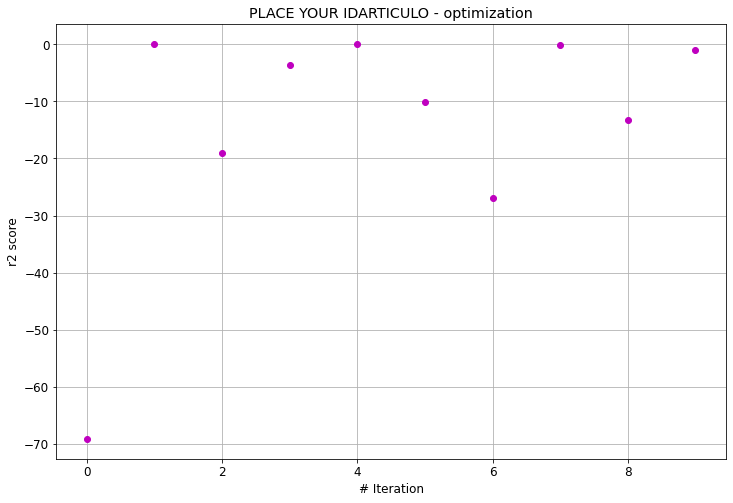

In [19]:
show_optimizer_results([trial.value for trial in study.trials])

In [20]:
idArticulo = 4827
# {'ar': 7, 'ii': 1, 'ma': 10} 
result = arima_forecasting(df_time[[idArticulo]],  **study.best_params)

/home/dave-linux/.local/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


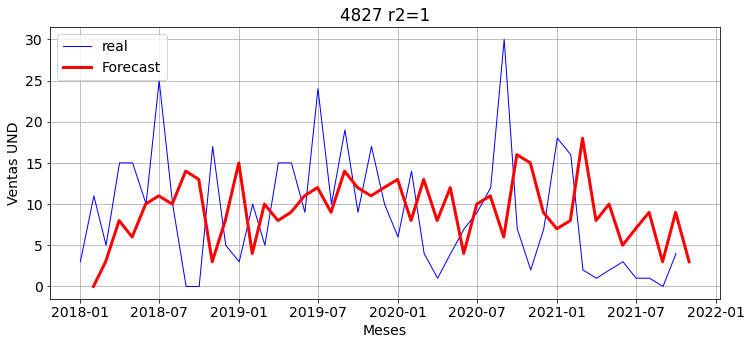

In [21]:
r2 = show_results_r2(df_time[[idArticulo]], result.fittedvalues. apply(lambda x: round(x,0)),idArticulo)


In [22]:
results = pd.DataFrame()
row = {'idArticulo':idArticulo, 'hyper':study.best_params, 'r2':r2 , 'model': 'ARIMA'}
results = results.append(row, ignore_index=True)
results.head()
results.to_csv(os.path.join(DATA_PATH, 'result', 'arima', 'arima_one.csv'), index=False)